# Subsoil schematisation and parametrisation

In order to run the ROSE model it is necessary to have information about the subsoil. 

For the analysis of railway lines the build-up of the subsoil plays a critical role on the behaviour of the infrastructure. Railway tracks cover large lenghts of different subsoil conditions, therefore it is necessary to take into account the subsoil spatial variability.

In ROSE the subsoil and the effect of its variability on the response of railway tracks, has been accounted for by means of a stochastic subsoil model. The stochastic subsoil model defines build-up scenario’s that are constructedby combining subsoil information (such as in situ and laboratory geotechnical testing) with geological knowledge. This approach has been derived from the guidelines to assess and design flood defences in the Netherlands.

The SOS is available for the entire A2 corridor. The SOS is being extended to cover the entire ProRail network.

## Create the SOS for the A2 corridor
The processing of the SOS is available under data_proc

In [1]:
import numpy as np
from data_proc import SoS

In [2]:
sos = SoS.ReadSosScenarios("../data/SoS/soilprofiles.csv",
                           "../data/SoS/20201102_Prorail_parameters_SOS.csv",
                           "../data/SoS/segments.csv",
                           "../data/SoS/Segments_TKI_v2.shp"
                          )

In [3]:
sos.SOS

{}

In [4]:
sos.create_segments()

In [5]:
sos.SOS

{'Segment 1001': {'scenario 1': {'probability': 8.1,
   'soil_layers': {'soil_name': ['H_Aa_ht',
     'P_Wdz_zf',
     'P_Wls_s',
     'P_Wdz_zf',
     'P_Rbk_kz',
     'P_Wdz_zf'],
    'top_level': [21.5, 18.5, 16.5, 14.5, 7.0, 5.0],
    'b': [0.004, 0.004, 0.084, 0.004, 0.1174, 0.004],
    'friction_angle': [32.5, 30.0, 27.5, 30.0, 22.5, 30.0],
    'poisson': [0.25, 0.25, 0.4, 0.25, 0.45, 0.25],
    'Young_modulus': [103.3, 244.3, 225.3, 244.3, 217.2, 244.3],
    'gamma_wet': [19.0, 19.0, 16.2, 19.0, 15.0, 19.0],
    'damping': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
    'gamma_dry': [17.0, 17.0, 15.6, 17.0, 15.0, 17.0],
    'c': [0.0001, 0.0001, 0.0032, 0.0001, 0.0051, 0.0001],
    'Su': ['NaN', 'NaN', 50.0, 'NaN', 40.0, 'NaN'],
    'shear_modulus': [41.3, 97.7, 81.7, 97.7, 74.9, 97.7],
    'a': [0.001, 0.001, 0.0067, 0.001, 0.0088, 0.001],
    'm': ['NaN', 'NaN', 0.8, 'NaN', 0.8, 'NaN'],
    'cohesion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'POP': ['NaN', 'NaN', 10.0, 'NaN', 10.0, 'NaN

In [6]:
sos.dump("./results/sos.json")

In [7]:
sos.plot_sos(output_folder="./results/SOS_plots")

## Determine the subsoil stiffness and damping properties

The dynamic soil spring stiffness and dashpot damping, that are required for the dynamic train-track analyses, were computed by means of a semi-analytical cone model based on one-dimensional wave propagation. This model assumes that the load is applied to a disk at the surface, which induces stresses on an area that increases with depth; the displacements are constant at the cross section of the cone. Discontinuities can be modelled by assuming at the interface between two layers that one cone leads to the creation of two new cones: reflected and refracted. This allows the modelling of multi-layered soils. The cone method has been extensively applied, because it has the advantage of providing an accurate numerical solution with limited computational efforts. In ROSE, the dynamic stiffness, Kdyn and damping, D, follow the definition:

<img src="https://render.githubusercontent.com/render/math?math=K_{dyn}=\Re \left(S\right)">
<img src="https://render.githubusercontent.com/render/math?math=D=\frac{\Im \left(S \right)}{\omega}">

where S is the dynamic stiffness matrix (complex frequency response function) and ω the angular frequency.

### Define the ballast properties
The SOS only contains the subsoil. The ballast needs to be added

In [8]:
G0 = 40e6
poisson = 0.2
density = 2000
damping = 0.05
thickness = 1
ballast = ["ballast", G0, poisson, density, damping, thickness]

In [9]:
from run_rose import run_wolf

In [10]:
new_soil = run_wolf.read_file(r"./results/sos.json", ballast)

In [11]:

for soil in new_soil:
    print(soil[0])

Segment 1001_scenario 1
Segment 1001_scenario 2
Segment 1001_scenario 3
Segment 1001_scenario 4
Segment 1001_scenario 5
Segment 1001_scenario 6
Segment 1001_scenario 7
Segment 1001_scenario 8
Segment 1002_scenario 1
Segment 1002_scenario 2
Segment 1002_scenario 3
Segment 1002_scenario 4
Segment 1002_scenario 5
Segment 1002_scenario 6
Segment 1002_scenario 7
Segment 1003_scenario 1
Segment 1003_scenario 2
Segment 1003_scenario 3
Segment 1003_scenario 4
Segment 1004_scenario 1
Segment 1004_scenario 2
Segment 1004_scenario 3
Segment 1004_scenario 4
Segment 1005_scenario 1
Segment 1005_scenario 2
Segment 1005_scenario 3
Segment 1005_scenario 4
Segment 1005_scenario 5
Segment 1005_scenario 6
Segment 1006_scenario 1
Segment 1006_scenario 2
Segment 1006_scenario 3
Segment 1007_scenario 1
Segment 1007_scenario 2
Segment 1007_scenario 3
Segment 1007_scenario 4
Segment 1008_scenario 1
Segment 1008_scenario 2
Segment 1008_scenario 3
Segment 1008_scenario 4
Segment 1008_scenario 5
Segment 1008_sce

In [12]:
# run wolf for the first two segments : 15 files
omega = np.linspace(0, 314, 100)
run_wolf.run_wolf(new_soil[:15], omega, output=r"./results/dyn_stiffness", plots=True)

Segment 1001_scenario 1
Segment 1001_scenario 2
Segment 1001_scenario 3
Segment 1001_scenario 4
Segment 1001_scenario 5
Segment 1001_scenario 6
Segment 1001_scenario 7
Segment 1001_scenario 8
Segment 1002_scenario 1
Segment 1002_scenario 2
Segment 1002_scenario 3
Segment 1002_scenario 4
Segment 1002_scenario 5
Segment 1002_scenario 6
Segment 1002_scenario 7


In [13]:
import json
with open(r'./results/dyn_stiffness/Kdyn_Segment 1001_scenario 1.json', "r") as f:
    data = json.load(f)
print(data.keys())

dict_keys(['omega', 'complex dynamic stiffness', 'stiffness', 'damping'])


In [14]:
import matplotlib.pylab as plt
from data_proc import sensar
sensar_data = sensar.read_geopackage("../data/Sensar/data.gpkg")

## Update SOS with InSar data
InSar data is available for the A2 corridor (through Sensar).
In data_proc there are tools to read and process the InSar dataset.

In [15]:
sensar_data["1"].keys()

dict_keys(['coordinates', 'dates', 'settlements', 'coverage_quality'])

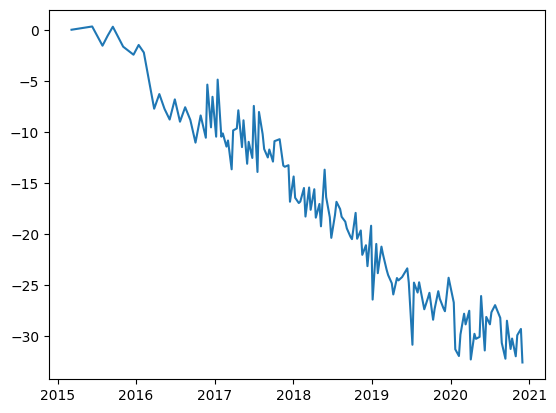

In [16]:
plt.plot(sensar_data["1"]["dates"], sensar_data["1"]["settlements"])

In [17]:
sensar.save_sensar_data(sensar_data, "./results/settlements.pickle")

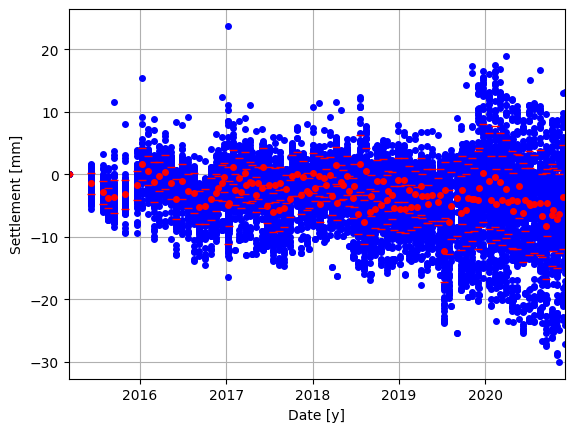

In [18]:
name = "Segment 1030"
sos.SOS[name]

# get coordinates of current segments
coordinates = np.array(list(sos.SOS[name].values())[0]['coordinates'])

# get coordinate limits
xlim = [min(coordinates[:,0]), max(coordinates[:,0])]
ylim = [min(coordinates[:,1]), max(coordinates[:,1])]     

# get date limits from sensar data and fugro data
sensar_dates = list(sensar_data.values())[0]["dates"]

# add plot of Sensar settlement measurements within the current segment
sensar_items_within_bounds = sensar.get_all_items_within_bounds(sensar_data, xlim, ylim)
if sensar_items_within_bounds:
    _, _ = sensar.plot_settlements_from_item_list_over_time(sensar_items_within_bounds,date_lim=[min(sensar_dates), max(sensar_dates)])
    plt.grid()

The data can be filtered using Kalman Filtering.


In [19]:
sensar_filtered = sensar.filter_dataset(sensar_data)
sensar.save_sensar_data(sensar_filtered, "./results/settlements_filtered.pickle")

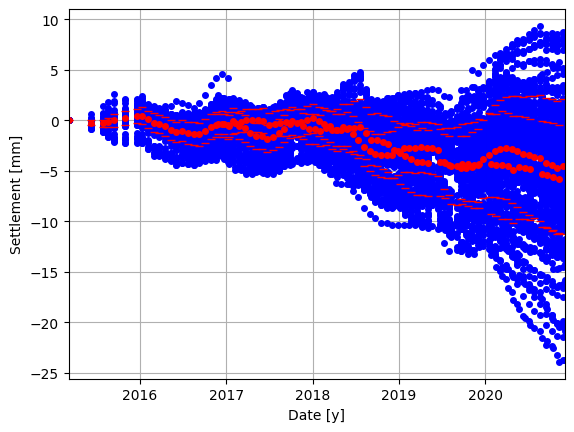

In [ ]:
name = "Segment 1030"
sos.SOS[name]

# get coordinates of current segments
coordinates = np.array(list(sos.SOS[name].values())[0]['coordinates'])

# get coordinate limits
xlim = [min(coordinates[:,0]), max(coordinates[:,0])]
ylim = [min(coordinates[:,1]), max(coordinates[:,1])]     

# get date limits from sensar data and fugro data
sensar_dates = list(sensar_filtered.values())[0]["dates"]

# add plot of Sensar settlement measurements within the current segment
sensar_items_within_bounds = sensar.get_all_items_within_bounds(sensar_filtered, xlim, ylim)
if sensar_items_within_bounds:
    _, _ = sensar.plot_settlements_from_item_list_over_time(sensar_items_within_bounds,date_lim=[min(sensar_dates), max(sensar_dates)])
    plt.grid()


### Clustering of data
The InSar data is used to perform clustering of the SOS types along the network.

The clustering is done by K-means.

<img src="static/k_means.png" width="600">

The clustering is performed at each SOS segment, with the InSar data that is within that SOS segment. The number of classes corresponds to the number of scenarios of the segment.


In [21]:
from data_proc import cluster

cluster.main("./results/settlements.pickle", "./results/sos.json", "./results/clustering", coord=True, plot=True)

Segment 1029: skyped 3 / 176


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1030: skyped 8 / 167


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1031: skyped 0 / 118


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1032: skyped 0 / 296


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1033: skyped 9 / 291


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1034: skyped 0 / 57


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1035: skyped 0 / 176
Segment 1036: skyped 0 / 79


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1037: skyped 0 / 120


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1038: skyped 0 / 99


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1039: skyped 3 / 425


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1040: skyped 0 / 299


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1041: skyped 0 / 202


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1042: skyped 0 / 173


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1043: skyped 0 / 115


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1044: skyped 0 / 221


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1045: skyped 0 / 241


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1046: skyped 0 / 41


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1047: skyped 0 / 260


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1048: skyped 2 / 281


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1049: skyped 0 / 100


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1050: skyped 0 / 192


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1051: skyped 0 / 184


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1052: skyped 0 / 82


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1053: skyped 0 / 142
Segment 1054: skyped 0 / 71


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1055: skyped 0 / 81


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1056: skyped 0 / 142


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1057: skyped 2 / 81


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1058: skyped 1 / 433


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1059: skyped 0 / 59


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1060: skyped 3 / 113


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1061: skyped 0 / 41
Segment 1062: skyped 0 / 104


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1063: skyped 3 / 491


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1064: skyped 1 / 458


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1065: skyped 0 / 977


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1066: skyped 0 / 117


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1067: skyped 0 / 606


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1068: skyped 0 / 177


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1069: skyped 0 / 383


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1070: skyped 0 / 325


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1071: skyped 0 / 1402


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segment 1072: skyped 34 / 4028


/home/bruno/software_dev/rose/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster.main("./results/settlements_filtered.pickle", "./results/sos.json", "./results/clustering_filtered", coord=True, plot=True)

Segment 1030: skyped 8 / 167
Segment 1031: skyped 0 / 118
Segment 1032: skyped 0 / 296
Segment 1033: skyped 9 / 291
Segment 1034: skyped 0 / 57
Mean score 0.402034223140077
Maximum 0.473115293199019
Minimum 0.3393871527590183
